In [2]:
import Pkg
using Plots, DelimitedFiles, Colors, Random, Statistics
using Distributed

length(Sys.cpu_info())
addprocs(4) ;

In [3]:
@everywhere using Random, Distributed, KernelDensity

In [4]:
const hour = 3600
const day = 24*hour
const year = 365*day

step_str = "185"

step = 185*day # time step for the simulation
step_out = 185*day # time step to save output
Tmax = 80*year

Nsim = 1000 ; # number of simulations

In [5]:
@everywhere struct mtDNA 
    rates::Vector{Real}
    unique_id::Int
    parent_id::Int
    status::String
    
    function mtDNA(rates, unique_id, parent_id, status)
        if !(status in ["wild", "mutant"])
            error("Molecules must be of type 'wild' or 'mutant' ")
        end
        if status=="wild"
            new(rates, unique_id, parent_id, status)
        elseif status=="mutant"
            new(rates, unique_id, parent_id, status)
        end
    end
end 

In [6]:
@everywhere rates(mol::mtDNA) = mol.rates
@everywhere unique_id(mol::mtDNA) = mol.unique_id
@everywhere parent_id(mol::mtDNA) = mol.parent_id
@everywhere status(mol::mtDNA) = mol.status 

In [7]:
@everywhere function counter(system_state)::Vector{Float64}
    """
    Calculates the population size for wild and mutant type
    """
    copy_num = length(system_state)
    W = sum([1 for mol in system_state if status(mol)=="wild"])
    return [W, copy_num-W]
end

In [8]:
@everywhere function transform_summ(popdym)::Array{Float64, 2}
    """
    Transforms the population sizes in to copy number and mutation load
    """
    copy_num = popdym[:,1] .+ popdym[:,2]
    
    mut_load = zeros(length(copy_num))*NaN
    nonzero_idx = copy_num .!= 0.0
    mut_load[nonzero_idx] .=  popdym[nonzero_idx,2] ./ copy_num[nonzero_idx]
    
    return hcat(copy_num, mut_load)
end

In [8]:
@everywhere function agented(init::Vector{mtDNA}, Tmax::Real, dt::Real, dtout::Real)::Array{Union{Float64, Missing}}
    N = trunc(Int, Tmax/dt) + 1
    Nout = trunc(Int, Tmax/dtout) + 1
    system_state = init
    current_id = length(init) + 1
    popdym = Array{Float64}(undef, (2,Nout))
    C0 = length(init)
    
    target = 0.0
    tt = 0.0
    i = 1
    for _=1:N
        while tt>=target && i<=Nout
            popdym[:,i] = counter(system_state)
            target += dtout
            i += 1
        end
        
        molecules_to_remove = Vector{Int}()
        new_molecules = Vector{mtDNA}()
        for mol_ind=1:length(system_state)
            molecule = system_state[mol_ind]
            roll = rand(Float64)
            cdf = cumsum( rates(molecule) ) 
            if 0.0<roll && roll<cdf[1] # degredation
                append!( molecules_to_remove, mol_ind )
            elseif cdf[1]<roll && roll<cdf[2] # replication
                append!(molecules_to_remove, mol_ind)
                for j=1:2
                    current_id += 1
                    daughter = mtDNA([3.06e-8,3.06e-8,0]*dt, current_id, unique_id(molecule), status(molecule) )
                    push!(new_molecules, daughter)
                end
            elseif cdf[2]<roll && roll<=cdf[3] # mutation
            # mutation last as has smallest probability
               append!(molecules_to_remove, mol_ind)
                for j=1:2
                    current_id += 1
                    daughter = mtDNA([3.06e-8,3.06e-8,0]*dt, current_id, unique_id(molecule), ["wild","mutant"][j])
                    push!(new_molecules, daughter)
                end
            end
        end
        system_state = [mol for (i,mol) in enumerate(system_state) if !(i in molecules_to_remove) ]
        append!(system_state, new_molecules)
        tt += dt
        if length(system_state) == 0
            popdym[:,i:Nout] = zeros(2, Nout-i+1)
            return transform_summ(popdym')
        end
    end
    return transform_summ(popdym')
end

In [9]:
C0 = 200
h = 0.5
W0 = round.( C0.*(1 .-h), digits=0)
M0 = round.( C0.*h, digits=0)
inits = [mtDNA([3.06e-8, 3.06e-8, 0]*step, x,-1,"wild") for x=1:W0 ]# initial state of system
append!(inits, [mtDNA([3.06e-8, 3.06e-8, 0]*step, x,-1,"mutant") for x=W0+1:W0+M0] ) ;

In [10]:
# @time map(agented, Nlist, Tmaxs, Δts, Δtouts) 
"""
500 simple simulations: 950 seconds 
"""

"500 simple simulations: 950 seconds \n"

In [11]:
function par_map(Nsim, f, init, Tmax, dt, dtout)
    np = nworkers()  # determine the number of processes available
    results = Vector{Array{Union{Float64, Missing}}}(undef, Nsim)
    i = 1
    # function to produce the next work item from the queue.
    # in this case it's just an index.
    nextidx() = (idx=i; i+=1; idx)
    @sync begin
        for p=1:np
            if p != myid() || np == 1
                @async begin
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        results[idx] = remotecall_fetch(f, p, inits, Tmax, dt, dtout)
                    end
                end
            end
        end
    end
    results
end

par_map (generic function with 1 method)

In [12]:
@time simulations = par_map(Nsim, agented, inits, Tmax, step, step_out) ; 
"""
time step = 200 days
time taken: ~2 seconds
4 workers, 1000 simulations

time step = 150 days
time taken: ~ 8 seconds
4 workers, 1000 simulations

time step = 150 days (code change to while loop)
step_out = 7 days
time taken: ~12 seconds
4 workers, 1000 simulations


time step = 100 days
time taken: 11 seconds
4 workers, 1000 simulations

time step = 50 days
time taken: 20 seconds
4 workers, 1000 simulations

time step = 25 days
simple simulation: 32 seconds
4 workers, 1000 simulations

time step = 10 days
time taken: 70 seconds
4 workers, 1000 simulations

time step = 5 days
time taken: 135 seconds
4 workers, 1000 simulations

time step = 2 days
time taken: 337
4 workers, 1000 simulations

time step = 1 day
time taken: 720 seconds
4 workers, 1000 simulations

time step = 1 hour
simple simulation : [a long f***ing time] 6700 seconds
(legit just 24 times longer than the day)
4 workers, 500 siulations
""" ;

  8.804953 seconds (5.41 M allocations: 260.503 MiB, 0.56% gc time, 4.51% compilation time)


In [13]:
function quantiles(sims, p)
    """
    returns quantile summaries from simulations
    """
    Nsim = length(sims) # Nsim: number of simulations
    n = size(sims[1])[1] # length of one simulation
    out = Array{Float64}(undef, n,length(p),2)
    for t=1:n
        out[t,:,1] = quantile(skipmissing([sims[i][t,1] for i=1:Nsim]), p)
        out[t,:,2] = quantile(skipmissing([sims[i][t,2] for i=1:Nsim]), p)
    end
    out
end

quantiles (generic function with 1 method)

In [14]:
sims_qntl = quantiles(simulations, [0.025,0.25,0.5,0.75,0.975]) ;

In [15]:
myBlack = colorant"rgb(0,0,0,0.1)"
ts = [0:step_out:Tmax;]./year;

In [16]:
n = trunc(Int, Tmax/step_out)
sim_mat = Array{Union{Float64, Missing}}(undef, (n+1,2,Nsim))

for i=1:Nsim
    sim_mat[:,:,i] = simulations[i]
end

In [17]:
p1 = plot(ts, sim_mat[:,1,:], color=myBlack, legend=false, title="Copy Number")
p2 = plot(ts, sim_mat[:,2,:], color=myBlack, legend=false, title="Mutation Load")
plot(p1, p2, layout=(1,2), legend=false)
savefig(string("Simulations/PDF/abm_simulations_",step_str,"d.pdf"))

In [18]:
p3 = plot(ts, sims_qntl[:,:,1], title="Copy Number Quantiles")
p4 = plot(ts, sims_qntl[:,:,2], title="Mutation Load Quantiles")
plot(p3, p4, layout=(1,2), legend=false)
savefig(string("Simulations/PDF/abm_qntls_",step_str,"d.pdf"))

In [19]:
writedlm(string("Simulations/CN_qnt_abm_",step_str,"d.txt"), sims_qntl[:,:,1])
writedlm(string("Simulations/ML_qnt_abm_",step_str,"d.txt"), sims_qntl[:,:,2])

In [2]:
"""
WHAT'S THE TIME
""" ;

In [29]:
@everywhere function par_times(Nsim, f, inits, Tmax, step, step_out)
    np = nworkers()            # Number of processes available.
    Nout = trunc(Int, Tmax/step_out) + 1 # dimension for output
    output = Array{Float64}(undef, Nsim) # Where we will write the results. As we do not know
                             # the type (Integer, Tuple...) we write "Any"
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
                                       # In this case it is just an index.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[idx] = @elapsed remotecall_fetch(f, p, inits, Tmax, step, step_out)
                    end
                end
            end
        end
    end
    output
end

In [39]:
sim_times = par_times(Nsim, agented, inits, Tmax, step, step_out)

mkpath("Simulations")
writedlm(string("Simulations/abm_",step_str,"d_times.txt"), sim_times) ;

In [37]:
dens = kde(sim_times)
density_points = hcat(dens.x, dens.density)

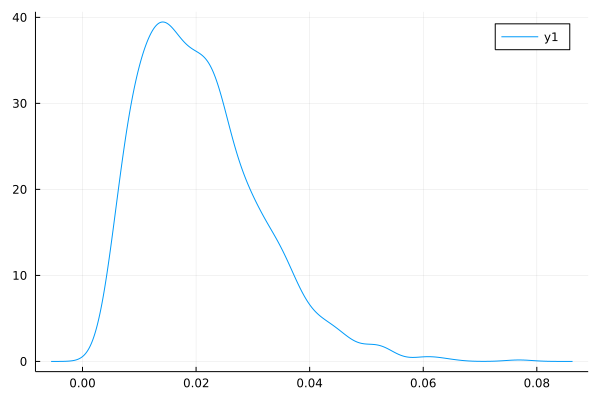

In [36]:
plot(dens.x, dens.density)